In [2]:
import trimesh
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import h5py
import json

from ibex.transforms.seg2seg import DownsampleMapping
from ibex.skeletonization.generate_skeletons import TopologicalThinning, FindEndpointVectors, FindEdges
from ibex.utilities.dataIO import ReadSkeletons
from scipy.ndimage.morphology import distance_transform_edt

from sklearn.decomposition import PCA

from tqdm import tqdm_notebook as tqdm

import matplotlib.cm as cm

from scipy import ndimage
from skimage.morphology import medial_axis
from scipy.ndimage.morphology import binary_fill_holes
import ipyvolume as ipv

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# in_dir = '/home/abhimanyu/final_data/pyramid25_aligned/voxel'
# in_path = '/mnt/coxfs01/donglai/data/JWR/snow_cell/cell128nm/seg_abhi/pyramid25.h5'
# seg_id = 207
# in_path = os.path.join(os.path.join(in_dir, str(seg_id)), 'seg.h5')
# in_h5 = h5py.File(in_path,'r')
# segments = np.array(in_h5['main']).astype(np.int64)
# in_h5.close()

In [3]:
# def DownSampleSegs(in_dir, out_dir, factor=(2, 2, 2)):
#     f1, f2, f3 = factor
#     in_subdir_list = os.listdir(in_dir)
#     seg_file = 'seg.h5'
#     for seg_id in in_subdir_list:
#         subdir_file_list = os.listdir(os.path.join(in_dir, seg_id))
#         # Check if the sub-directory contains a .stl file
#         if seg_file in subdir_file_list:
#             out_subdir = os.path.join(out_dir, seg_id)
#             if not os.path.exists(out_subdir): 
#                 os.makedirs(out_subdir)
#             out_seg_file_path = os.path.join(out_subdir, seg_file)
#             in_seg_file_path = os.path.join(os.path.join(in_dir, seg_id), seg_file)
#             in_h5 = h5py.File(in_seg_file_path,'r')
#             segments = np.array(in_h5['main']).astype(np.int64)[::f1, ::f2, ::f3]
#             out_h5 = h5py.File(out_seg_file_path, 'w')
#             out_h5.create_dataset('main', data=segments)
#             out_h5.close
#             in_h5.close
#             print('Created {}/{}'.format(seg_id, seg_file))

In [4]:
def DownSampleSegs(in_dir, out_dir, factor=(2, 2, 2), file_list=None):
    f1, f2, f3 = factor
    if file_list is None:
        file_list = os.listdir(in_dir)
    seg_file = '.h5'
    for fname in file_list:
        # Check if the sub-directory contains a .stl file
        if seg_file in fname:
            out_seg_file_path = os.path.join(out_dir, fname.replace('8-8-30nm', '30nm3'))
            in_seg_file_path = os.path.join(in_dir, fname)
            with h5py.File(in_seg_file_path,'r') as in_h5:
                orig_segments = np.array(in_h5['main']).astype(np.int64) 
                segments = orig_segments[::f1, ::f2, ::f3]
            with h5py.File(out_seg_file_path, 'w') as out_h5:
                out_h5.create_dataset('main', data=segments, \
                                      compression='gzip', compression_opts=9)
            print('Created {} Orig: {} New:{}'.format(fname, \
                                                      orig_segments.shape, segments.shape))

In [5]:
# in_dir = '/home/abhimanyu/final_data/pyramid25_aligned/voxel'
# out_dir = '/home/abhimanyu/final_data/pyramid25_aligned/voxel_down2'
in_dir = '/mnt/coxfs01/donglai/data/JWR/mito/cb_final'
out_dir = '/var/www/html/abhi/hires_final_data/hires_vols'
# DownSampleSegs(in_dir, out_dir, factor=(1,2,2), file_list=['cell47_8-8-30nm.h5'])

In [6]:
def GetMesh(cell_dir, stl_id):
    mesh_path = os.path.join(cell_dir, 'stl/' + str(stl_id) + '/0_0_0.stl')
    in_mesh = trimesh.load_mesh(mesh_path)
    return in_mesh

In [7]:
# # cell_dir = '/home/abhimanyu/final_data/cell47_aligned//'
# # cell_dir = '/home/abhimanyu/final_data/cell47_8x8x30_aligned'
# # cell_dir = '/home/abhimanyu/final_data/pyramid25_aligned/'
# cell_dir = '/home/abhimanyu/final_data/cell84_60nm3/'

# stl_id = 7
# in_mesh = GetMesh(cell_dir, stl_id)
# in_mesh.show()

### Code for extracting single segment h5 files from full volume

In [8]:
def ReadSeg(voxel_dir, seg_id):
    seg_path = os.path.join(voxel_dir, '{:.0f}/seg.h5'.format(seg_id))
    segments = np.array(h5py.File(seg_path,'r')['main']).astype(np.int64)
    return segments

In [9]:
# voxel_dir = '/home/abhimanyu/final_data/cell47_aligned/voxel'
# seg_id = 38
# seg = ReadSeg(voxel_dir, seg_id)

In [10]:
# %time
# dt = distance_transform_edt(seg, return_distances=True)

In [11]:
def SaveSingleH5(in_path, out_dir, seg_id, buf=5.0):
    in_h5 = h5py.File(in_path,'r')
    segments = np.array(in_h5['main']).astype(np.int64)
    segments[segments != seg_id] = 0
    new_dir = os.path.join(out_path, str(seg_id))
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    # find smaller bounding box for individual segment
    x_ = np.any(segments, axis=(1,2))
    y_ = np.any(segments, axis=(0,2))
    z_ = np.any(segments, axis=(0,1))
    
    x_min, x_max = np.where(x_)[0][[0, -1]]
    y_min, y_max = np.where(y_)[0][[0, -1]]
    z_min, z_max = np.where(z_)[0][[0, -1]]
    
    buf = int(buf)
    x_min = max(0, x_min-buf)
    y_min = max(0, y_min-buf)
    z_min = max(0, z_min-buf)
    x_max = min(segments.shape[0]-1, x_max+buf)
    y_max = min(segments.shape[1]-1, y_max+buf)
    z_max = min(segments.shape[2]-1, z_max+buf)
    
    fname = 'seg.h5'
    out_h5 = h5py.File(os.path.join(new_dir, fname), 'w')
    out_h5.create_dataset('main', data=segments[x_min:x_max, y_min:y_max, z_min:z_max])
    out_h5.close
    print('Created {}'.format(fname))

In [12]:
# if False:
# #     in_path = '/mnt/boslfs/Donglai/jwr_mito/cb/final/cell47_60nm.h5'
# #     out_path = '/home/abhimanyu/final_data/cell47_aligned/voxel'
#     in_path = '/mnt/coxfs01/donglai/data/JWR/snow_cell/cell128nm/seg_abhi/pyramid25.h5'
#     out_path = '/home/abhimanyu/final_data/pyramid25_aligned/voxel'
#     seg_id = 2006
#     SaveSingleH5(in_path, out_path, seg_id)

In [13]:
# Extract individual segs for entire cell
def SaveAllSegs(in_path, out_dir, seg_list=None):
    with h5py.File(in_path,'r') as in_h5:
        all_segments = np.array(in_h5['main']).astype(np.int64)
    print('Orig Size ', all_segments.shape)
    ids_ = np.unique(all_segments)
    for seg_id in ids_:
        if seg_id == 0 or ((seg_list is not None) and \
                           (seg_id not in seg_list)): continue
        t0 = time.time()
        segments = all_segments.copy()
        segments[segments != seg_id] = 0
        new_dir = os.path.join(out_path, str(seg_id))
        if not os.path.isdir(new_dir):
            os.makedirs(new_dir)
        # find smaller bounding box for individual segment
        x_ = np.any(segments, axis=(1,2))
        y_ = np.any(segments, axis=(0,2))
        z_ = np.any(segments, axis=(0,1))

        x_min, x_max = np.where(x_)[0][[0, -1]]
        y_min, y_max = np.where(y_)[0][[0, -1]]
        z_min, z_max = np.where(z_)[0][[0, -1]]
        print('New size ', x_max-x_min, y_max-y_min, z_max-z_min)
        fname = 'seg.h5'
        with h5py.File(os.path.join(new_dir, fname), 'w') as out_h5:
            out_h5.create_dataset('main', data=segments[x_min:x_max, y_min:y_max, z_min:z_max], \
                                 compression='gzip', compression_opts=9)

        del segments
        print('Created h5 for {:.0f}, Time: {:.2}s'.format(seg_id, time.time()-t0))

In [14]:
# # # in_path = '/mnt/boslfs/Donglai/jwr_mito/cb/final/cell47_60nm.h5'
# # # out_path = '/home/abhimanyu/final_data/cell47_aligned/voxel'

# # seg_list = [7,14,17,28,212,566,1645,1676,1883,2303,3119,3158,3161,4193,4245,4510,5517,5744, \
# #             1728, 70, 2981, 5773, 2765, 5567, 5520, 4244, 3605, 5592, 3514, 5023, 1884, 5205, \
# #             1861,3648, 3713, 2, 259, 740, 2311, 2856, 5001, 4363, 1868, 2287, 2229, 2070, \
# #             5513, 5419, 87, 5301,3842, 4, 5254, 2763, 3695, 4240, 147, 4628, 4830, 2703, 3710, \
# #             2047,2565, 5617, 4531, 3761, 3283, 3717,3640, 31]

# # cell73
# # seg_list = [379,517,970,1219,1382,1463,1469,99,156,436,756,1238,1239, \
# #             1264,1388,130, 683, 1031, 1195, 1453, 82, 340, 1077, 1335, \
# #             825, 1145, 217, 94,1457, 423, 655, 478, 303]

# # cell89
# # seg_list = [1,16,32,1179,1344,1681,1709,1901,1985,2158,2249,2301,1576, \
# #             1646, 1552, 19, 1910, 1727,1445, 2246, 2282, 2290, 1524, 2393, 90, 2341]

# # cell76
# # seg_list = [69,940,1218,97, 866, 1001, 938, 1037, 1193, 1528, 1307,2, 3, \
# #             5, 1064, 1070, 1160, 1623, 1466, 701,1577, 114, 621, 630]

# # cell94
# # seg_list = [1, 1123, 1735, 1610, 1010, 183, 1144, 1530,1743, 1764, 1963, \
# #             1327,1689, 1865, 1592, 4, 1031,1240, 8, 1343, 929]

# # cell27
# # seg_list = [681,915,1541,888, 1153, 1011, 673, 665,1543,1000, 1392, 1029,1544, 880,1393]

# #pyr25
# seg_list = [67,69,70,75,83,26,27,29,30,34,35,43,53,54,56,63,90,114,32,41,92,97,99,100,104]

# pyr5
# seg_list = [86,55,59,48,91]

#cell68
# seg_list = [16,169,218,316,4,39,349,56,457,252]

#cell107
seg_list = [5, 14, 883, 181, 598, 823, 126]

#cell78
# seg_list = [115,468,566,753,796,1018,32,884,576]

#cell69
# seg_list = [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 16, 20, 24, 32, 39, 52, 863, 877, 916, 959]

#cell83
# seg_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 19, 20, 24, 32, 39, 916, 959, 1630, 2013, 2071, 2182]

cell_id = 107
in_path = '/mnt/boslfs/Donglai/jwr_mito/cb/final/cell{}_60nm.h5'.format(cell_id)
# in_path = '/mnt/boslfs/Donglai/jwr_mito/cb/final/cell78_60nm.h5'
# in_path = '/var/www/html/abhi/hires_final_data/hires_vols/cell{}_30nm3.h5'.format(cell_id)
# in_path = '/mnt/coxfs01/donglai/data/JWR/snow_cell/cell128nm/seg_abhi/pyramid5.h5'
# out_path = '/home/abhimanyu/hires_final_data/cell{}_30nm3_aligned/voxel/'
out_path = '/home/abhimanyu/final_data/cell{}_60nm3_aligned/voxel/'.format(cell_id)
# SaveAllSegs(in_path, out_path, seg_list=seg_list)

In [15]:
':'.join([str(x) for x in seg_list])

'5:14:883:181:598:823:126'

### Code for creating skeleton from single mito volume

In [16]:
## From Srujan's notebook

def CreateMetaFile(seg_name, resolution, seg_shape):
    if not os.path.isdir('./meta/'):
        os.mkdir('./meta/')
    meta = open("./meta/" + seg_name +'.meta', "w")
    meta.write("# resolution in nm\n")
    meta.write("%dx%dx%d\n"%(resolution[2], resolution[1], resolution[0]))
    meta.write("# grid size\n")
    meta.write("%dx%dx%d\n"%(seg_shape[2], seg_shape[1], seg_shape[0]))
    meta.close()
    
def CheckIds(seg, verbose=False):
    """
    From Srujan's code:
    checks if all IDs in segmentation are consecutive
    Args:
        seg (ndarray): segmentation data
    """
    seg_ids = np.unique(seg)
    max_id = np.max(seg_ids)
    n_ids = len(seg_ids)
    try:
        assert max_id == n_ids-1
    except:
        missing_ids = np.sort(np.array(list(set(range(max_id+1)).difference(set(seg_ids)))))
        if verbose:
            print "Error! Labels in segmentation are not consecutive. %d IDs are missing"%(len(missing_ids))
            print missing_ids
            
def Relabel(seg):
    """
    From Srujan's code:
    Relabels a segmentation such that max ID = # objects
    Args:
        seg (ndarray): 3D segmentation
    Returns:
        seg_relabeled (ndarray)
    """
    seg_ids = np.unique(seg)
    n_ids = len(seg_ids)
    max_id = np.max(seg_ids)
    if max_id == n_ids-1:
        return seg
    missing_ids = np.sort(np.array(list(set(range(max_id+1)).difference(set(seg_ids)))))
    seg_relabel = seg
    for i in range(len(missing_ids)):
        if i==len(missing_ids)-1:
            ids_to_correct = range(missing_ids[i]+1, max_id+1)
        else:
            ids_to_correct = range(missing_ids[i]+1, missing_ids[i+1])
        for j in ids_to_correct:
            seg_relabel[seg==j] = j-(i+1) #TODO (Jeff): speed this up using object-wise bounding boxes
    return seg_relabel

In [17]:
def CreateSkeleton(voxel_dir, seg_id, skel_dir='./', plot_type=None, return_dt=False, \
                  in_res=None, out_res=None):
    seg_path = os.path.join(voxel_dir, '{:.0f}/seg.h5'.format(seg_id))
    segments = np.array(h5py.File(seg_path,'r')['main']).astype(np.int64)
    seg_name = 'temp'
    in_resolution = (30, 48, 48)
    if in_res is not None:
        in_resolution = in_res
    out_resolution = (30, 48, 48)
    if out_res is not None:
        out_resolution = out_res
    
    CreateMetaFile(seg_name, in_resolution, segments.shape)
    # Following code not needed as each segment file has a single organelle
    #     CheckIds(segments)
    #     segments = Relabel(segments)
    segments[segments > 0] = 1
    segments = binary_fill_holes(segments).astype('int64')
    
    DownsampleMapping(seg_name, segments, output_resolution=out_resolution)
    TopologicalThinning(seg_name, segments, skeleton_resolution=out_resolution)
    FindEndpointVectors(seg_name, skeleton_algorithm='thinning', skeleton_resolution=out_resolution)
    FindEdges(seg_name, skeleton_algorithm='thinning', skeleton_resolution=out_resolution)
    t0_read = time.time()
    skeletons = ReadSkeletons(seg_name, skeleton_algorithm='thinning', downsample_resolution=out_resolution, read_edges=True)
    print('Read skeletons in {:.3f}s'.format(time.time() - t0_read))
    
    if plot_type is not None:
        t0_plt = time.time()
        node_list = skeletons[1].get_nodes()
        nodes = np.stack(node_list).astype(float)
        junction_idx = skeletons[1].get_junctions()
        junctions = nodes[junction_idx, :]
        ends = skeletons[1].get_ends()
        jns_ends = np.vstack([junctions, ends])
        
        IX, IY, IZ = 2, 1, 0
        ipv.figure()
        if plot_type == 'nodes':
            nodes = ipv.scatter(nodes[:,IX], nodes[:,IY], nodes[:,IZ], \
                                size=0.5, marker='sphere', color='blue')
        elif plot_type == 'edges':
            edges = skeletons[1].get_edges().astype(float)
            for e1, e2 in edges:
                if not ((e1[IX] == e2[IX]) and (e1[IY] == e2[IY]) and (e1[IZ] == e2[IZ])):
                    ipv.plot([e1[IX], e2[IX]], [e1[IY], e2[IY]], [e1[IZ], e2[IZ]], \
                             color='blue');

        jns = ipv.scatter(jns_ends[:,IX], jns_ends[:,IY], jns_ends[:,IZ], \
                          size=0.85, marker='sphere', color='red')
        ipv.pylab.style.axes_off()
        ipv.pylab.style.box_off()

        ipv.save(os.path.join(skel_dir, 'skel' + str(seg_id) + '.html'))
        print('Plot created and saved in {:.3f}s'.format(time.time() - t0_plt))
    if return_dt:
        t0_dt = time.time()
        dt = distance_transform_edt(segments, return_distances=True)
        print('Distance Transform computed in {:.3f}s'.format(time.time() - t0_dt))
        return skeletons[1], dt
    else:
        return skeletons[1]

In [18]:
# # voxel_dir = '/home/abhimanyu/final_data/cell47_aligned/voxel/'
# voxel_dir = '/home/abhimanyu/final_data/cell47_30nm3_aligned/voxel'
# # skel_dir = '/var/www/html/abhi/final_data/cell47'
# skel_dir = './'
# seg_id = 94
# s = CreateSkeleton(voxel_dir, seg_id, skel_dir=skel_dir, plot_type='edges', return_dt=False);

## Code for saving mesh as HTML

In [19]:
def SaveMeshAsHTML(cell_dir, stl_id, mesh_dir='./'):
    in_mesh = GetMesh(cell_dir, stl_id)
    IX, IY, IZ = 2, 1, 0
    x, y, z = in_mesh.vertices[:,IX].astype(float), \
                in_mesh.vertices[:,IY].astype(float), \
                in_mesh.vertices[:,IZ].astype(float)
    triangles = in_mesh.faces
    ipv.figure()
    mesh = ipv.plot_trisurf(x, y, z, triangles=triangles, color='skyblue')
    ipv.pylab.style.axes_off()
    ipv.pylab.style.box_off()
    ipv.save(os.path.join(mesh_dir, 'mesh' + str(stl_id) + '.html'))

In [20]:
# # cell_dir = '/home/abhimanyu/final_data/cell47_30nm3_aligned/'
# # # mesh_dir = '/var/www/html/abhi/final_data/cell47'
# cell_dir = '/home/abhimanyu/final_data/pyramid25_aligned/'
# mesh_dir = '/var/www/html/abhi/final_data/pyramid25'
# stl_id = 69
# SaveMeshAsHTML(cell_dir, stl_id, mesh_dir=mesh_dir)

## Code for creating graph from skeleton

In [21]:
def AddToDict(d, p1, p2):
    if p1 not in d:
        d[p1] = []
    d[p1] += [p2]

def AddEdge(graph, p1, p2):
    AddToDict(graph, p1, p2)
    AddToDict(graph, p2, p1)

def AddEdgeAndWeight(graph, p1, p2, wt_dict, wt, th_dict, th=None):
    AddEdge(graph, p1, p2)
    wt_dict[(p1, p2)] = wt
    wt_dict[(p2, p1)] = wt
    if th is not None:
        th_dict[(p1, p2)] = th
        th_dict[(p2, p1)] = th

def GetAdjDict(adj_mat):
    """
    INPUT:  adj_mat is a compact adjacency matrix produced by Ibex,
            of dimensions |E| x 2 where each tuple is the index
            of source and target node.
    OUTPUT: Dict where keys are node indices, and for each key,
            the value is the list of adjacent nodes.
    """
    adj_dict = {}
    for p1, p2 in adj_mat:
        if p1 != p2: 
            AddToDict(adj_dict, p1, p2)
            AddToDict(adj_dict, p2, p1)
    return adj_dict

In [22]:
def GetEdgeList(graph, wt_dict=None, th_dict=None):
    edgelist = []
    for key in graph:
        for val in graph[key]:
            if val > key:
                if wt_dict is None:
                    edgelist += [[key, val]]
                else:
                    edgelist += [[key, val, {'weight' : wt_dict[(key, val)], \
                                            'thick' : th_dict[(key, val)]}]]
    return edgelist

In [23]:
# def GetEdgeList(graph, wt_dict=None, th_dict=None):
#     if wt_dict is None:
#         edgelist = [[key, val] if val > key for val in graph[key] for key in graph]
#     else:
#         edgelist = [[key, val, {'weight' : wt_dict[(key, val)], \
#                                 'thick' : th_dict[(key, val)]}] \
#                     if val > key for val in graph[key] for key in graph]
#     return edgelist

In [24]:
def ModifiedBFS(node_list, orig_graph, new_graph, visited, node_coords, dt=None, \
                use_euclid=True, debug=False):
    def IsJoint(node, graph):
        return (len(graph[node]) == 2)
    
    def IsEdge(n1, n2, graph):
        if n1 in graph and n2 in graph[n1]:
            return True
        return False
    
    def Euclidean(n1, n2, coords):
        return np.linalg.norm(coords[n1,:] - coords[n2,:])
    
    def AvgThick(n1, n2, coords, dt):
        if dt is None: return 0.0
        x1,y1,z1 = coords[n1,:]
        x2,y2,z2 = coords[n2,:]
        return 0.5*(dt[x1,y1,z1] + dt[x2,y2,z2])
    
    def GetNext(src, adj, orig_graph, coords, use_euclid=True, dt=None):
        prev = src
        cur = adj
        path = [prev]
        weight = 1.0
        if use_euclid: 
            weight = Euclidean(prev, cur, coords)
        thickness = AvgThick(prev, cur, coords, dt)*weight
        while IsJoint(cur, orig_graph):
            nxt = orig_graph[cur][int(orig_graph[cur][0] == prev)]
            prev = cur
            cur = nxt
            cur_wt = 1.0
            if use_euclid:
                cur_wt = Euclidean(prev, cur, coords)
            weight += cur_wt
            thickness += AvgThick(prev, cur, coords, dt)*cur_wt
            path += [prev]
        path += [cur]
        try:
            thickness = thickness/weight
        except:
            print('Total edge weight should not be zero.')
        return cur, weight, thickness, path
    
    if debug:
        for key in orig_graph:
            print(key, orig_graph[key])
    new_node = max(orig_graph) 
    weight_dict = {}
    thick_dict = {}
    while len(node_list) > 0:
        src = node_list.pop(0)
        visited[src] = True
        adj_nodes = orig_graph[src]
        if debug: print('Source {:.0f}'.format(src))
        self_loops_ = []
        for adj in adj_nodes:
            if debug: print('  Adj {:.0f}'.format(adj))
            nxt, wt, th, path = GetNext(src, adj, orig_graph, node_coords, use_euclid=use_euclid, \
                                       dt=dt)
            if debug: print('    Nxt {:.0f}'.format(nxt))
            if (not visited[nxt]) or (src == nxt):
                # if there is no edge yet between src & nxt in new_graph, add one
                if (not IsEdge(src, nxt, new_graph)) and (src != nxt):
                    AddEdge(new_graph, src, nxt)
                    if debug: print('      Add Edge {:.0f}-{:.0f}'.format(src, nxt))
                    weight_dict[(src, nxt)] = wt
                    weight_dict[(nxt, src)] = wt
                    thick_dict[(src, nxt)] = th
                    thick_dict[(nxt, src)] = th
                # if there is an edge betwen src & nxt in new_graph, add another path
                # of length two edges between src & nxt, with a new node in between. 
                # (This step allows capturing multiple paths between src and nxt.)
                # (The reason for adding a new node: Networkx won't allow multiple paths).
                elif src != nxt:
                    new_node += 1
                    AddEdgeAndWeight(new_graph, src, new_node, weight_dict, wt/2.0, \
                                    thick_dict, th)
                    AddEdgeAndWeight(new_graph, new_node, nxt, weight_dict, wt/2.0, \
                                    thick_dict, th)
                    if debug: 
                        print('      Add Edge {:.0f}-{:.0f}'.format(src, new_node))
                        print('      Add Edge {:.0f}-{:.0f}'.format(new_node, nxt))
                # If src is same as nxt then there is a self-loop in the skeleton topology.
                # This code snippet captures that loop by creating a triangular loop with
                # the src as one of the vertices and two new nodes.
                elif (src == nxt):
                    if (path not in self_loops_) and (list(reversed(path)) not in self_loops_):
                        self_loops_ += [path]
                        new_node += 1
                        n1 = new_node
                        new_node += 1
                        n2 = new_node
                        AddEdgeAndWeight(new_graph, src, n1, weight_dict, wt/3.0, \
                                        thick_dict, th)
                        AddEdgeAndWeight(new_graph, n1, n2, weight_dict, wt/3.0, \
                                        thick_dict, th)
                        AddEdgeAndWeight(new_graph, n2, nxt, weight_dict, wt/3.0, \
                                        thick_dict, th)
                        if debug: 
                            print('      Add Edge {:.0f}-{:.0f}'.format(src, n1))
                            print('      Add Edge {:.0f}-{:.0f}'.format(n1, n2))
                            print('      Add Edge {:.0f}-{:.0f}'.format(n2, nxt))
                    
                if (nxt not in node_list) and (src != nxt):
                    node_list += [nxt]
    return weight_dict, thick_dict

In [ ]:
def MergeTwoEdges(G):
    while True:
        adj_, two_node_ = None, None
        for node in G:
            if len(G[node].keys()) == 2:
                adj_ = G[node].keys()
                two_node_ = node
                break
        if adj_ is None:
            break
        m, n = G[two_node_].keys()
        wm, wn = G[two_node_][m]['weight'], G[two_node_][n]['weight']
        # add edge between m and n
        G.add_edge(m, n, weight=(wm+wn))
        # delete orphan node
        G.remove_node(two_node_)
    return G

def DeLeaf(G, thresh=None, avoid_n=-1):
    leaves = []
    for n in G:
        adj_ = G[n].keys()
        if avoid_n in adj_:
            continue
        if len(adj_) == 1:
            if thresh is None:
                leaves += [n]
            elif G[n][adj_[0]]['weight'] < thresh:
                leaves += [n]
    for n in leaves:
        G.remove_node(n)
    return G

def GetWt(G):
    return np.sum([x['weight'] for x in G.edges.values()])

def PlotLeavesHist(G, bins=None):
    leaves = []
    for n in G:
        adj_ = G[n].keys()
        if len(adj_) == 1:
            leaves += [G[n][adj_[0]]['weight']]
    if bins is None:
        _ = plt.hist(leaves, edgecolor='black', linewidth=1.2)
    else:
        _ = plt.hist(leaves, bins=bins, edgecolor='black', linewidth=1.2)
    _ = plt.title('Total Graph Wt. {:.0f}, Leaves Wt. {:.0f}'.format(GetWt(G), np.sum(leaves)), fontsize=12)
    plt.show()
    
def PlotLeavesPercentile(G, seg_id, prefix='(No Prune) '):
    leaves = []
    for n in G:
        adj_ = G[n].keys()
        if len(adj_) == 1:
            leaves += [G[n][adj_[0]]['weight']]
    perc_wts = []
    perc = np.linspace(1, 100, 49)
    for q in perc:
        perc_wts += [np.percentile(leaves, q)]
    fig = plt.gcf()
    _ = plt.plot(perc, perc_wts)
    title_str = prefix + 'Seg {}'.format(seg_id)
    _ = plt.title(prefix + 'Seg {}'.format(seg_id) + \
                  'Total Graph Wt. {:.0f}, Leaves Wt. {:.0f}'.format(GetWt(G), np.sum(leaves)), fontsize=12)
    fig.set_size_inches(9, 6)
    fig.savefig('./leaves/' + title_str + '.png')
    plt.show()
    
def GetThreshold(G, base_percentile=50):
    wts = np.array([d['weight'] for d in G.edges.values()])
    threshold = np.percentile(wts, base_percentile)
    perc_wts = wts/np.sum(wts)
    base_perc_wt = np.percentile(perc_wts, base_percentile)
    pivots = [base_percentile + 0.5*(j+1) for j in range(70)]
    for p in pivots:
        if p < 100 and np.percentile(perc_wts, p) > 20*base_perc_wt:
            threshold = np.percentile(wts, p)
            break
    return threshold

def GetLeafPercentile(G, perc=50):
    leaves = []
    for n in G:
        adj_ = G[n].keys()
        if len(adj_) == 1:
            leaves += [G[n][adj_[0]]['weight']]
    t = np.percentile(leaves, perc)
    print('Threshold for leaves is {:.1f}'.format(t))
    return t

def GetNumLeaves(G, n):
    num_l = 0
    for m in G[n].keys():
        if len(G[m].keys()) == 1:
            num_l += 1
    return num_l

def GetMaxDegree(G):
    max_n, max_deg, min_leaves = None, 0, 1000
    for n in G:
        if len(G[n].keys()) > max_deg:
            max_deg = len(G[n].keys())
            max_n = n
            min_leaves = GetNumLeaves(G, n)
        elif len(G[n].keys()) == max_deg:
            num_l = GetNumLeaves(G, n)
            if num_l < min_leaves:
                max_n = n
                min_leaves = num_l
    return max_n, max_deg

def AddCenter(G, max_n):
    deg = len(G[max_n].keys())
    max_node = max(G.nodes.keys()) + 1
    G.add_nodes_from([max_node + i for i in range(deg)])
    adj_ = G[max_n].keys()
    for i, n in enumerate(adj_):
        wt = G[max_n][n]['weight']
        G.add_edge(max_node + i, n, weight=wt)
        G.add_edge(max_node + i, max_node + (i+1)%deg, weight=1.0)
    G.remove_node(max_n)
    
def PrintLeafWts(G):
    leaves = []
    for n in G:
        adj_ = G[n].keys()
        if len(adj_) == 1:
            leaves += [G[n][adj_[0]]['weight']]
    print(sorted(leaves))

In [25]:
def BFS(node_list, orig_graph, new_graph, visited, node_coords, dt=None, \
                use_euclid=True, debug=False):
    def IsJoint(node, graph):
        return (len(graph[node]) == 2)
    
    def IsEdge(n1, n2, graph):
        if n1 in graph and n2 in graph[n1]:
            return True
        return False
    
    def Euclidean(n1, n2, coords):
        return np.linalg.norm(coords[n1,:] - coords[n2,:])
    
    def AvgThick(n1, n2, coords, dt):
        if dt is None: return 0.0
        x1,y1,z1 = coords[n1,:]
        x2,y2,z2 = coords[n2,:]
        return 0.5*(dt[x1,y1,z1] + dt[x2,y2,z2])
    
    def GetNext(src, adj, orig_graph, coords, use_euclid=True, dt=None):
        prev = src
        cur = adj
        path = [prev]
        weight = 1.0
        if use_euclid: 
            weight = Euclidean(prev, cur, coords)
        thickness = AvgThick(prev, cur, coords, dt)*weight
        while IsJoint(cur, orig_graph):
            nxt = orig_graph[cur][int(orig_graph[cur][0] == prev)]
            prev = cur
            cur = nxt
            cur_wt = 1.0
            if use_euclid:
                cur_wt = Euclidean(prev, cur, coords)
            weight += cur_wt
            thickness += AvgThick(prev, cur, coords, dt)*cur_wt
            path += [prev]
        path += [cur]
        try:
            thickness = thickness/weight
        except:
            print('Total edge weight should not be zero.')
        return cur, weight, thickness, path
    
    if debug:
        for key in orig_graph:
            print(key, orig_graph[key])
    new_node = max(orig_graph) 
    weight_dict = {}
    thick_dict = {}
    while len(node_list) > 0:
        src = node_list.pop(0)
        visited[src] = True
        adj_nodes = orig_graph[src]
        if debug: print('Source {:.0f}'.format(src))
            
        for adj in adj_nodes:
            if debug: print('  Adj {:.0f}'.format(adj))
            nxt, wt, th, path = GetNext(src, adj, orig_graph, node_coords, use_euclid=use_euclid, \
                                       dt=dt)
            if debug: print('    Nxt {:.0f}'.format(nxt))
            if (not visited[nxt]):
                    AddEdge(new_graph, src, nxt)
                    if debug: print('      Add Edge {:.0f}-{:.0f}'.format(src, nxt))
                    weight_dict[(src, nxt)] = wt
                    weight_dict[(nxt, src)] = wt
                    thick_dict[(src, nxt)] = th
                    thick_dict[(nxt, src)] = th
                    node_list += [nxt]
                    visited[nxt] = True
    return weight_dict, thick_dict

In [26]:
def GetGraphFromSkeleton(skel, dt=None, modified_bfs=True):
    adj_mat = skel.get_adj()
    orig_graph = GetAdjDict(adj_mat)
    node_coords = skel.get_nodes()
    
    new_graph = {}
    visited = [False]*len(node_coords)
    # find a source which has at least one incident edge
    src = None
    for i in range(len(node_coords)-1, -1, -1):
        if i in orig_graph and (False or len(orig_graph[i]) > 2): 
            src = i
            break
    if src is None:
        src = len(node_coords) - 1
    if modified_bfs:
        wt_dict, th_dict = ModifiedBFS([src], orig_graph, new_graph, visited, node_coords, dt=dt)
    else:
        wt_dict, th_dict = BFS([src], orig_graph, new_graph, visited, node_coords, dt=dt)
    return new_graph, wt_dict, th_dict

In [28]:
def DrawGraph(ax, edgelist, sz=1, labels=False, weighted=False, threshold=1.0, show_th=False, \
             show_wts=False, save_graphx=False, gx_dir=None, seg_id=None, percentile=None, \
             percent=None, prune_jns=True, is_tree=False):
   
    def ShrinkGraph(G, threshold, debug=False, prune_jns=True):
        """ 
            Do not contract an edge if edge part of a triangle loop 
            with length shorter than the threshold.
        """
        def GetOrphan(a1, a2, s1, s2, G):
            orphan_, other_, orph_node_ = None, None, None
            if len(s1) == 0 and len(s2) == 2: orphan_ = a2; other_ = a1;
            if len(s2) == 0 and len(s1) == 2: orphan_ = a1; other_ = a2;
            # if no edge exists between two adjacent nodes 
            # of orphan, then orphan can be deleted.
            if orphan_ is not None:
                orph_node_ = a1
                m, n = set(G[orphan_].keys()).difference({other_})
                if n not in G[m].keys():
                    return orph_node_
            return None
        if threshold == 0.0: return G
        if debug: PrintSummary(G)
        
        if percentile is not None:
            wts = np.array([d['weight'] for d in G.edges.values()])
            threshold = np.percentile(wts, percentile)
            perc_wts = wts/np.sum(wts)
            base_ = np.percentile(perc_wts, percentile)
            pivots = [percentile + 0.5*(j+1) for j in range(70)]
            for p in pivots:
                if p < 100 and np.percentile(perc_wts, p) > 50*base_:
                    threshold = np.percentile(wts, p)
                    print('Threshold found at {:.2f}'.format(p))
                    break
        delete_count = 0
        while True:
            wts = np.array([d['weight'] for d in G.edges.values()])
            if prune_jns:
                idx = np.asarray(wts < threshold).nonzero()[0]
            else:
                mask = [(len(G[e[0][0]].keys()) == 1) or (len(G[e[0][1]].keys()) == 1) \
                        for e in G.edges.items()]
                idx = np.asarray((wts < threshold) & mask).nonzero()[0]
            if len(idx) == 0:
                break
            u,v = None, None
            orphan_node = None
            # find a candidate edge to delete in this loop
            for i in idx:
                a1, a2 = G.edges.items()[i][0] 
                s1, s2 = set(G[a1].keys()).difference({a2}), \
                            set(G[a2].keys()).difference({a1})
                intersect_ = s1 & s2
                # If no common node in adjacency list then break
                if len(intersect_) == 0:
                    u, v = a1, a2
                    orphan_node = GetOrphan(a1, a2, s1, s2, G)
                    break
                # Else, make sure no triangular loop of decent size breaks
                else:
                    crucial_edge = False
                    for n in intersect_:
                        w1 = G.get_edge_data(n, a1)['weight']
                        w2 = G.get_edge_data(n, a2)['weight']
                        # if a loop (containing this edge) with 
                        # len > 3*thresh exists, don't delete this edge
                        if w1 + w2 > 3*threshold - wts[i]:
                            crucial_edge = True
                            break
                    if not crucial_edge:
                        u, v = a1, a2
                        orphan_node = GetOrphan(a1, a2, s1, s2, G)
                        break
            if u is None:
                break
            G = nx.contracted_nodes(G, u, v, self_loops=False)
            delete_count += 1
            if orphan_node is not None:
                m, n = G[orphan_node].keys()
                wm, wn = G[orphan_node][m]['weight'], G[orphan_node][n]['weight']
                # add edge between m and n
                G.add_edge(m, n, weight=(wm+wn))
                # delete orphan node
                G.remove_node(orphan_node)
            if debug: 
                print('Deleted edge {}-{}'.format(u, v))
                PrintSummary(G)
        print('Total edges deleted {}'.format(delete_count))
        return G
    
    G = nx.Graph()
    if not weighted:
        G.add_edges_from(edgelist)
        pos=graphviz_layout(G)
        nx.draw_networkx(G, pos=pos, node_size=sz, ax=ax, with_labels=labels,
                        font_size=8, font_color='white', font_weight='bold', edge_color='red')    
    else:
        G.add_edges_from(edgelist)
        
        t0_shrink = time.time()

        if is_tree:
            if False:
                factor = 5.0**(-3)
                wt = GetWt(G)
                t = factor*wt
                G = MergeTwoEdges(G)

                q0 = 20
                t0 = GetLeafPercentile(G, perc=q0)
                print('Original {:.0f}%ile weight {:.2f}'.format(q0, t0))
                for p in [25, 40, 80, 40, 20]:
                    t = GetLeafPercentile(G, perc=p)
                    G = DeLeaf(G, thresh=t)
                    G = MergeTwoEdges(G)

                G = ShrinkGraph(G, threshold=t0, prune_jns=True)
                G = DeLeaf(G, thresh=t0)
                G = MergeTwoEdges(G)
                max_n, max_deg = GetMaxDegree(G)

                if max_n in G.nodes.keys():
                    AddCenter(G, max_n)
        else:
            G = ShrinkGraph(G, threshold=threshold, prune_jns=True)

        if save_graphx:
            nx.write_gpickle(G, os.path.join(gx_dir, str(seg_id) + '_networkx.obj'))
        print('Graph shrunk in {:.2f}s'.format(time.time() - t0_shrink))
        if show_th:
            edge_dict = {e[0]: '({:.1f}, {:.1f})'.format(e[1]['weight'], \
                                                         e[1]['thick']) for e in G.edges.items()}
        else:
            edge_dict = {e[0]: '{:.1f}'.format(e[1]['weight']) for e in G.edges.items()}
        pos=graphviz_layout(G)
        nx.draw_networkx(G, pos=pos, node_size=sz, ax=ax, with_labels=labels,
                        font_size=5, font_color='white', font_weight='bold') #, edge_color='red')    
        if show_wts:
            nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_dict)

In [34]:
def MakeAndPlotGraph(voxel_dir, seg_id, graph_dir='./', threshold=0.0, show_graph=True, \
                     save_graph=True, skel=None, dt=None, use_dt=False, show_orig=True, \
                    gx_dir=None, save_graphx=False, percentile=None, in_res=(30,30,30), \
                    out_res=(30,30,30), show_wts=False, return_graph=False, prune_jns=True, \
                    modified_bfs=True):
    
    is_tree = False
    if not modified_bfs:
        is_tree = True
    
    # Create skeleton from voxels
    if skel is None:
        if use_dt:
            skel, dt = CreateSkeleton(voxel_dir, seg_id, return_dt=True, \
                                     in_res=in_res, out_res=out_res)
        else:
            skel = CreateSkeleton(voxel_dir, seg_id, return_dt=False, \
                                     in_res=in_res, out_res=out_res)
    # Create graph from skeleton
    t0_gr = time.time()
    new_graph, wt_dict, th_dict = GetGraphFromSkeleton(skel, dt=dt, \
                                                       modified_bfs=modified_bfs)
    print('Graph generated in {:.3f}s'.format(time.time() - t0_gr))
    
    # Create edge_lists to be used for plotting graph
    t0_ed = time.time()
    edgelist_new = GetEdgeList(new_graph, wt_dict, th_dict)
    if show_orig:
        edgelist_orig = GetEdgeList(GetAdjDict(skel.get_adj()))
    print('Retrieved edgelists for plotting in {:.3f}s'.format(time.time() - t0_ed))
    
    if show_graph:
        if show_orig:
            fig, ax = plt.subplots(2,1)
            DrawGraph(ax[0], edgelist_orig, sz=10) 
            ax[0].set_title('Skeleton Graph (All Nodes)', fontsize=14, fontweight='bold');
            DrawGraph(ax[1], edgelist_new, weighted=True, threshold=threshold, gx_dir=gx_dir, \
                     seg_id=seg_id, save_graphx=save_graphx, show_wts=show_wts, percentile=percentile, \
                     prune_jns=prune_jns, is_tree=is_tree)
            ax[1].set_title('Skeleton Graph (Only Junction Nodes)', fontsize=14, fontweight='bold');
            for i in [0,1]:
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
            fig.set_size_inches(18, 14)
        else:
            fig, ax = plt.subplots()
            print('Plotting graph..', is_tree)
            DrawGraph(ax, edgelist_new, weighted=True, threshold=threshold, gx_dir=gx_dir, \
                     seg_id=seg_id, save_graphx=save_graphx, show_wts=show_wts, percentile=percentile, \
                     prune_jns=prune_jns, is_tree=is_tree)
            ax.set_title('Skeleton Graph (Only Junction Nodes)', fontsize=14, fontweight='bold');
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            fig.set_size_inches(18, 7)
        if save_graph:
            fig.savefig(os.path.join(graph_dir, 'graph' + str(seg_id) + \
                                     '_thresh_{:.1f}.png'.format(threshold)))
    if return_graph:
        G = nx.Graph()
        G.add_edges_from(edgelist_new)
        return G

In [30]:
def SaveSkelAndMesh(in_dir, voxel_dir, seg_id, out_dir, verbose=True, return_dt=False, \
                   in_res=(120,120,120), out_res=(120,120,120), plot_type='nodes', \
                   save_mesh=True):
    # create and save skeleton
    if verbose: print('Creating and saving skeleton ...')
    if return_dt:
        skel, dt = CreateSkeleton(voxel_dir=voxel_dir, seg_id=seg_id, skel_dir=out_dir, \
                                  plot_type=plot_type, return_dt=True, in_res=in_res, out_res=out_res);
    else:
        skel = CreateSkeleton(voxel_dir=voxel_dir, seg_id=seg_id, skel_dir=out_dir, \
                              plot_type=plot_type, return_dt=False, in_res=in_res, out_res=out_res);
    # save mesh
    if save_mesh:
        if verbose: print('Saving triangle mesh ...')
        SaveMeshAsHTML(cell_dir=in_dir, stl_id=seg_id, mesh_dir=out_dir)
    if verbose: print('Done')
    if return_dt:
        return skel, dt
    else:
        return skel

In [ ]:
cell_id = 83


res = 60

seg_dict = {}
# cell47
seg_dict[47] = [7,94,422,508,522,2006,1043, 1195, 1796, 710, 107, 1459, 46, 440, 113, 1299, \
        1300, 1368, 858, 444,161, 459, 1252, 38, 102, 833, 779, 137, 267, 499, 944, \
        1265, 275, 308, 341, 218, 91, 1277, 85,1025, 1750, 1991, 73, 1515, 268, 493, \
        174, 79, 115, 437, 118, 857, 1433, 293,1025, 1411, 136, 268, 17, 916, 1433, \
        293, 166, 174, 437, 61, 319, 1991, 73, 79, 338, 1750, 857, 2271, 1123, 1515, \
        493, 115, 118,312, 1266, 204, 362, 394]
# cell84
seg_dict[84] = [7,14,17,28,212,566,1645,1676,1883,2303,3119,3158,3161,4193,4245,4510,5517,5744, \
            1728, 70, 2981, 5773, 2765, 5567, 5520, 4244, 3605, 5592, 3514, 5023, 1884, 5205, \
            1861,3648, 3713, 2, 259, 740, 2311, 2856, 5001, 4363, 1868, 2287, 2229, 2070, \
            5513, 5419, 87, 5301,3842, 4, 5254, 2763, 3695, 4240, 147, 4628, 4830, 2703, 3710, \
            2047,2565, 5617, 4531, 3761, 3283, 3717,3640, 31]
#cell73
seg_dict[73] = [379,517,970,1219,1382,1463,1469,99,156,436,756,1238,1239, \
            1264,1388,130, 683, 1031, 1195, 1453, 82, 340, 1077, 1335, \
            825, 1145, 217, 94,1457, 423, 655, 478, 303]
#cell89
seg_dict[89] = [1,16,32,1179,1344,1681,1709,1901,1985,2158,2249,2301,1576, \
            1646, 1552, 19, 1910, 1727,1445, 2246, 2282, 2290, 1524, 2393, 90, 2341]
# cell76
seg_dict[76] = [69,940,1218,97, 866, 1001, 938, 1037, 1193, 1528, 1307,2, 3, \
                5, 1064, 1070, 1160, 1623, 1466, 701,1577, 114, 621, 630]
# cell94
seg_dict[94] = [1, 1123, 1735, 1610, 1010, 183, 1144, 1530,1743, 1764, 1963, \
            1327,1689, 1865, 1592, 4, 1031,1240, 8, 1343, 929]
#cell27
seg_dict[27] = [681,915,1541,888, 1153, 1011, 673, 665,1543,1000, 1392, 1029,1544, 880,1393]

#cell68
seg_dict[68] = [16,169,218,316,4,39,349,56,457,252]

#cell107
seg_dict[107] = [122,  32,  566,  884]

#cell78
seg_dict[78] = [115,468,566,753,796,1018,32,884,576]

#cell69
seg_dict[69] = [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 16, 20, 24, 32, 39, 52, 863, 877, 916, 959]

#cell83
seg_dict[83] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 19, 20, 24, 32, 39, 916, 959, 1630, 2013, 2071, 2182]


# segs = [161]

cell_ids = [27, 47, 68, 69, 73, 76, 78, 83, 84, 89, 94]

for cell_id in cell_ids:
    in_dir = '/home/abhimanyu/final_data/cell{}_60nm3_aligned/'.format(cell_id)
    voxel_dir = os.path.join(in_dir, 'voxel')
    out_dir = '/var/www/html/abhi/final_data/cell{}/'.format(cell_id)
    gx_dir = os.path.join(out_dir, 'networkx_0_thresh_noloop')
    
    segs = seg_dict[cell_id]
    
    for seg_id in segs:
        skel, dt = None, None
    #     skel, dt= SaveSkelAndMesh(in_dir=in_dir, seg_id=seg_id, out_dir=out_dir, verbose=False, \
    #                               return_dt=False)
#         try:
#             skel = SaveSkelAndMesh(in_dir=in_dir, voxel_dir=voxel_dir, seg_id=seg_id, out_dir=out_dir, verbose=False, \
#                                   return_dt=False, in_res=(res,res,res), out_res=(res,res,res), plot_type='edges')
#         except:
#             continue
    #     MakeAndPlotGraph(voxel_dir=voxel_dir, seg_id=seg_id, graph_dir=out_dir, \
    #                          skel=skel, threshold=0.0, dt=dt, save_graphx=False)
        try: 
            threshold = 0.0
            MakeAndPlotGraph(voxel_dir=voxel_dir, seg_id=seg_id, graph_dir=out_dir, \
                                skel=skel, threshold=threshold, gx_dir=gx_dir, save_graphx=True, \
                             dt=dt, show_orig=False, use_dt=False, save_graph=False, \
                            modified_bfs=False)
        except:
            continue

Downsampling to resolution (30, 30, 30) in 1.0981490612 seconds
Topological thinning time for (30, 30, 30): 2.37227582932
Endpoint vector time for (30, 30, 30): 0.933407068253
Edge finding time for (30, 30, 30): 0.737906932831
Read skeletons in 0.337s
Graph generated in 7.996s
Retrieved edgelists for plotting in 0.004s
('Plotting graph..', True)
Graph shrunk in 0.13s
Done segment 67
Downsampling to resolution (30, 30, 30) in 1.04152083397 seconds
Topological thinning time for (30, 30, 30): 2.2107629776
Endpoint vector time for (30, 30, 30): 0.910665035248
Edge finding time for (30, 30, 30): 0.690690994263
Read skeletons in 0.233s
Graph generated in 5.764s
Retrieved edgelists for plotting in 0.004s
('Plotting graph..', True)
Graph shrunk in 0.13s
Done segment 69
Downsampling to resolution (30, 30, 30) in 0.836645126343 seconds
Topological thinning time for (30, 30, 30): 1.7593228817
Endpoint vector time for (30, 30, 30): 0.72040605545
Edge finding time for (30, 30, 30): 0.559639930725
R

/home/abhimanyu/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Done segment 92
Downsampling to resolution (30, 30, 30) in 1.0725479126 seconds
Topological thinning time for (30, 30, 30): 2.07680606842
Endpoint vector time for (30, 30, 30): 0.890310049057
Edge finding time for (30, 30, 30): 0.663054227829
Read skeletons in 0.104s
Graph generated in 2.314s
Retrieved edgelists for plotting in 0.002s
('Plotting graph..', True)
Graph shrunk in 0.02s
Done segment 97
Downsampling to resolution (30, 30, 30) in 1.09220290184 seconds
Topological thinning time for (30, 30, 30): 2.19946694374
Endpoint vector time for (30, 30, 30): 0.869903087616
Edge finding time for (30, 30, 30): 0.662487030029
Read skeletons in 0.099s
Graph generated in 2.618s
Retrieved edgelists for plotting in 0.002s
('Plotting graph..', True)
Graph shrunk in 0.02s
Done segment 99
Downsampling to resolution (30, 30, 30) in 1.15427803993 seconds
Topological thinning time for (30, 30, 30): 2.34319090843
Endpoint vector time for (30, 30, 30): 0.948648929596
Edge finding time for (30, 30, 30)

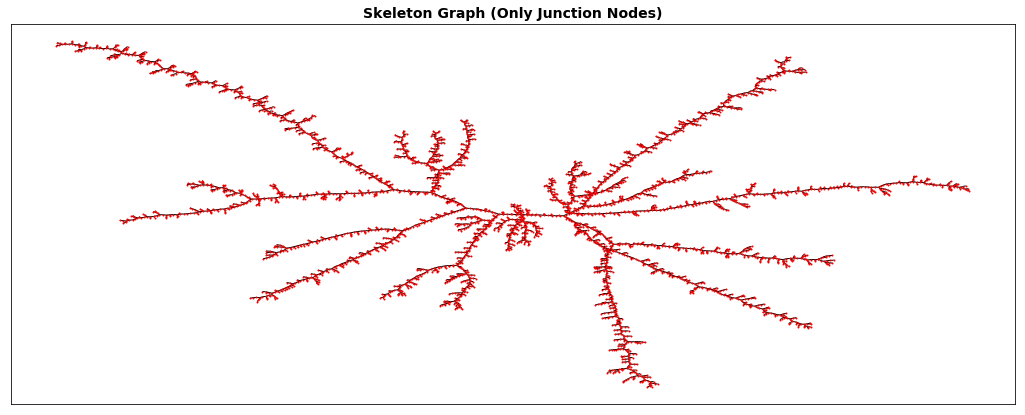

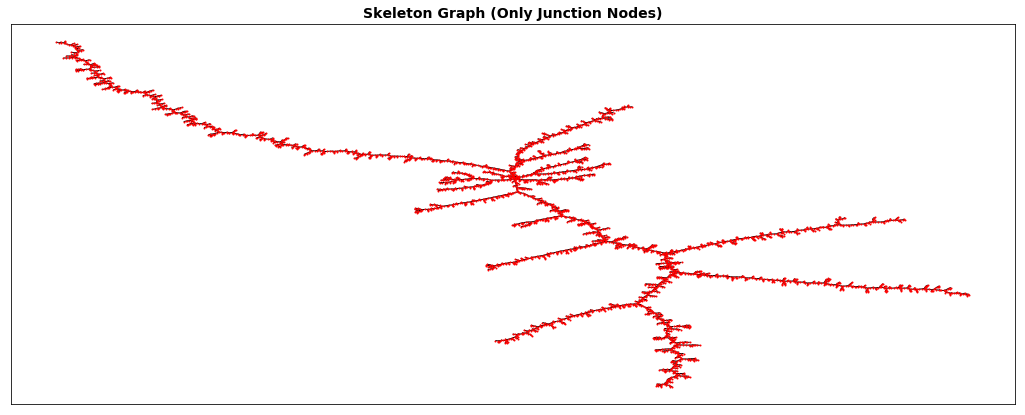

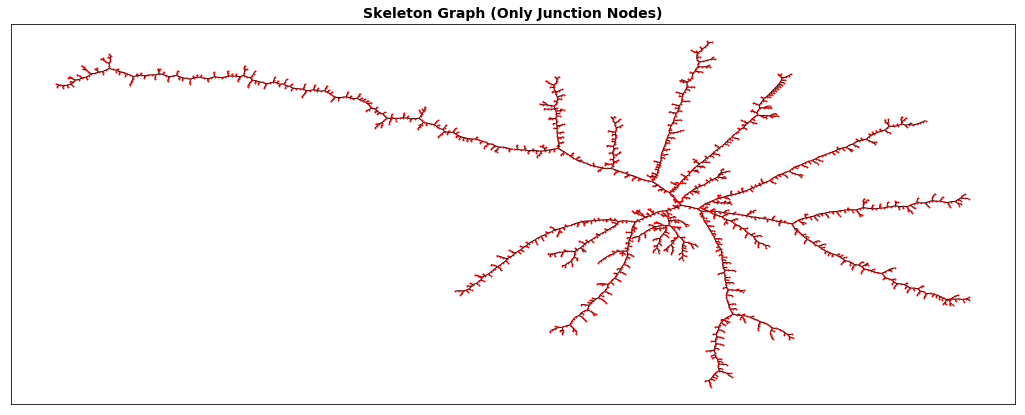

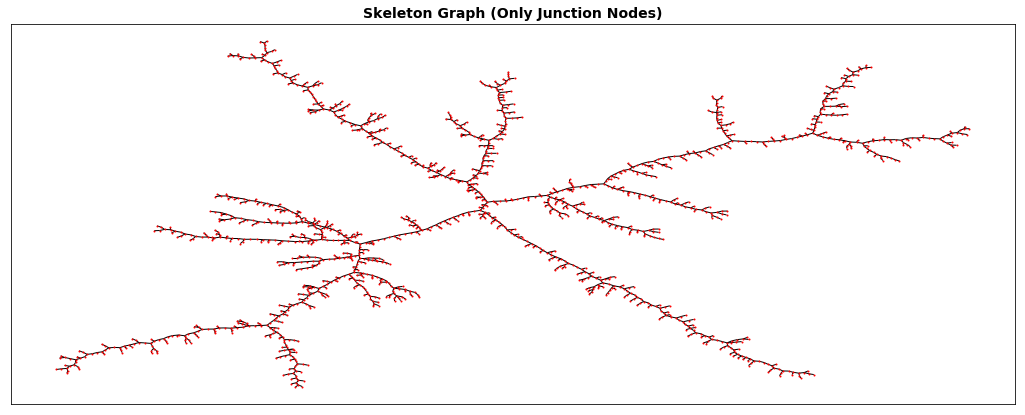

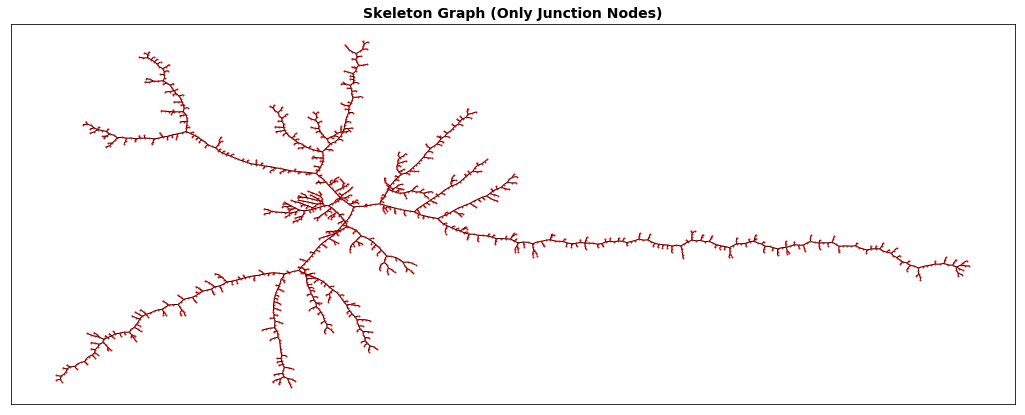

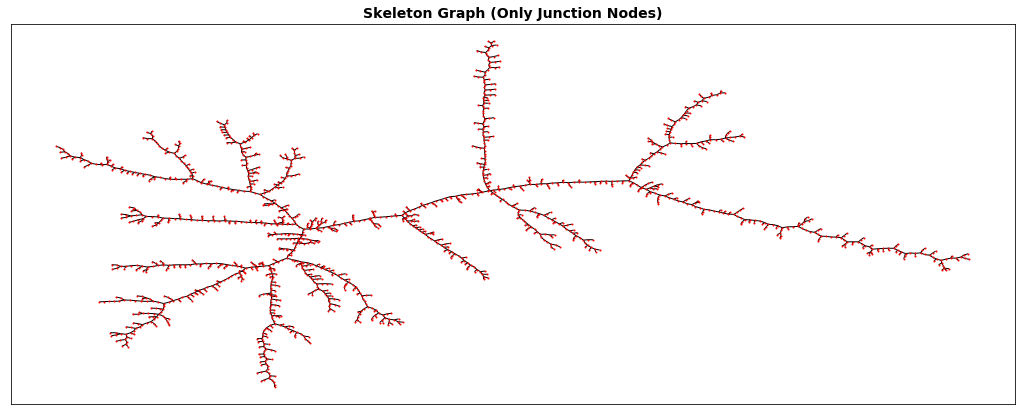

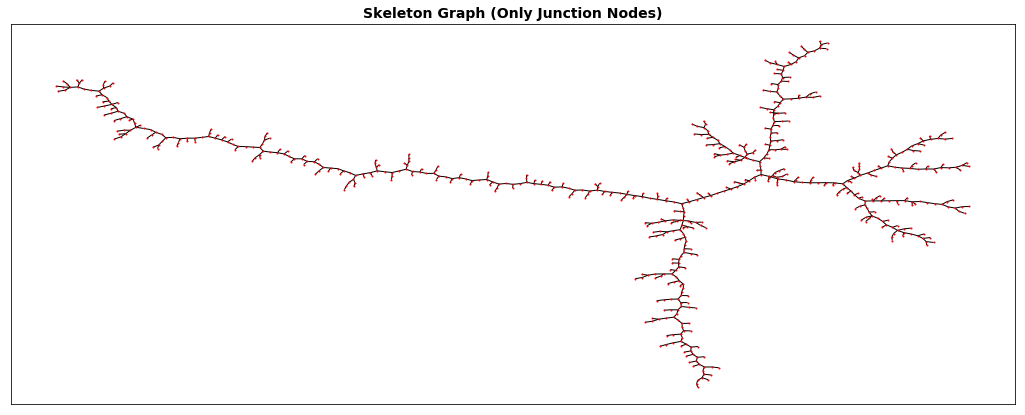

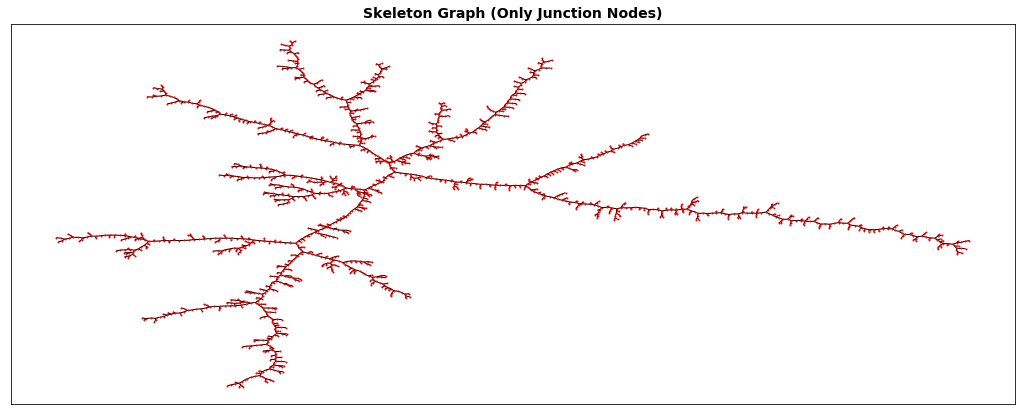

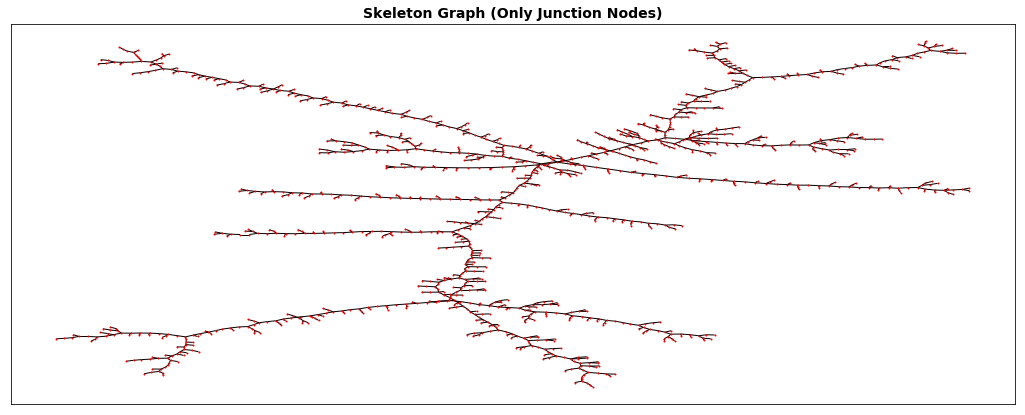

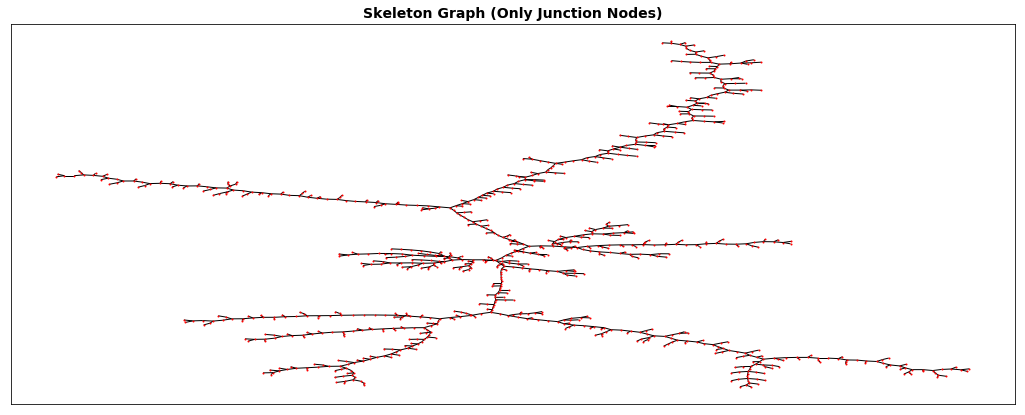

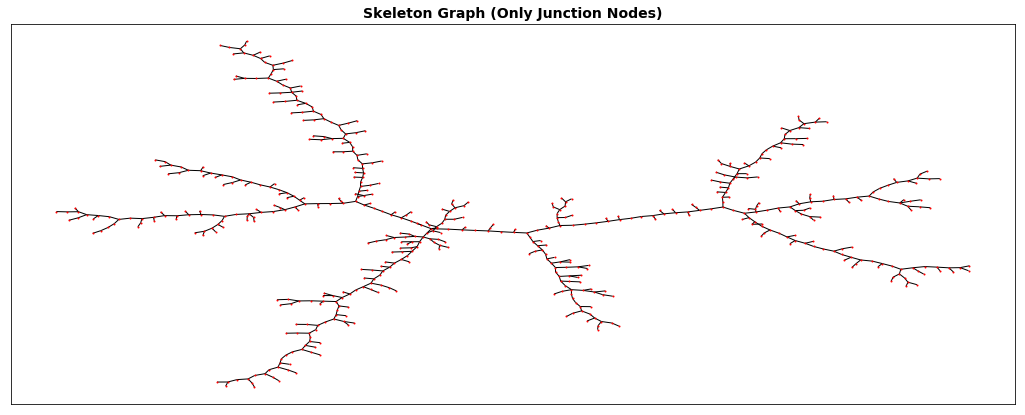

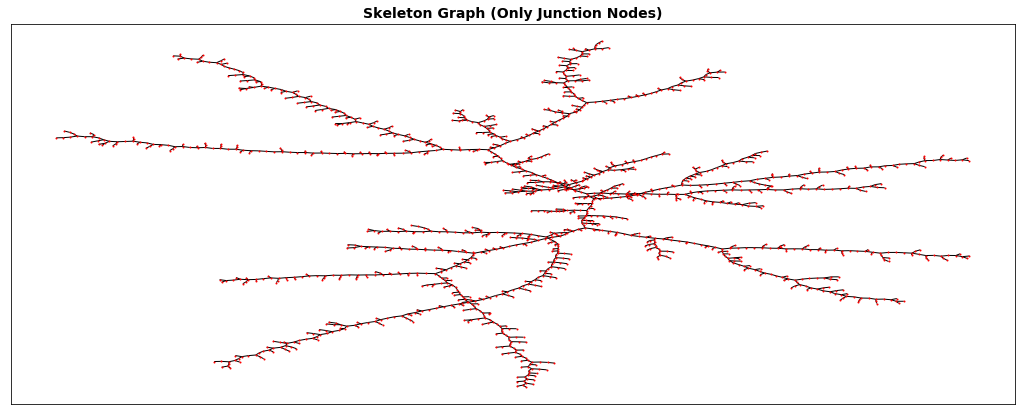

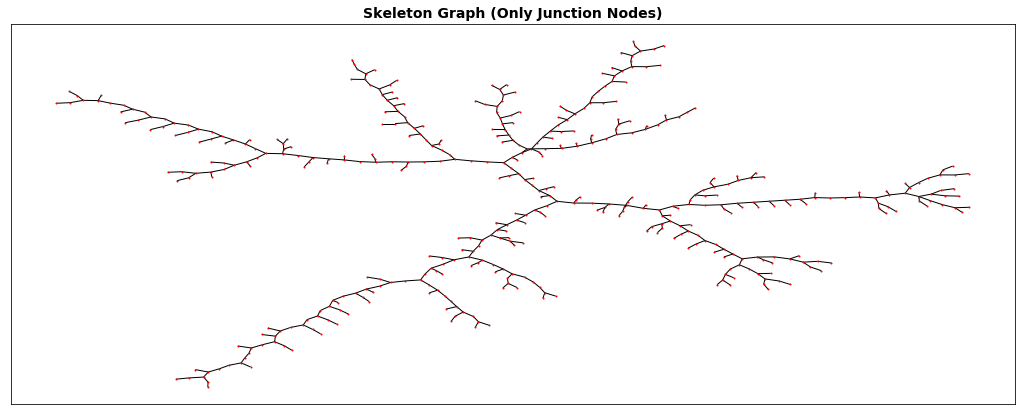

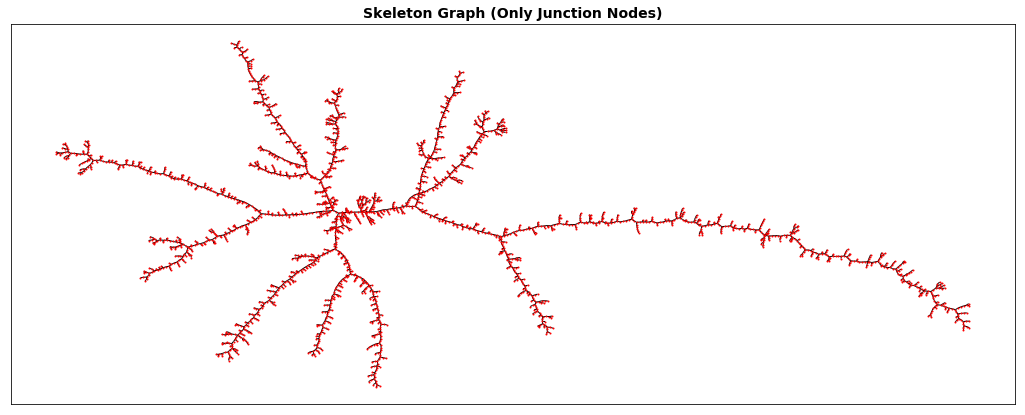

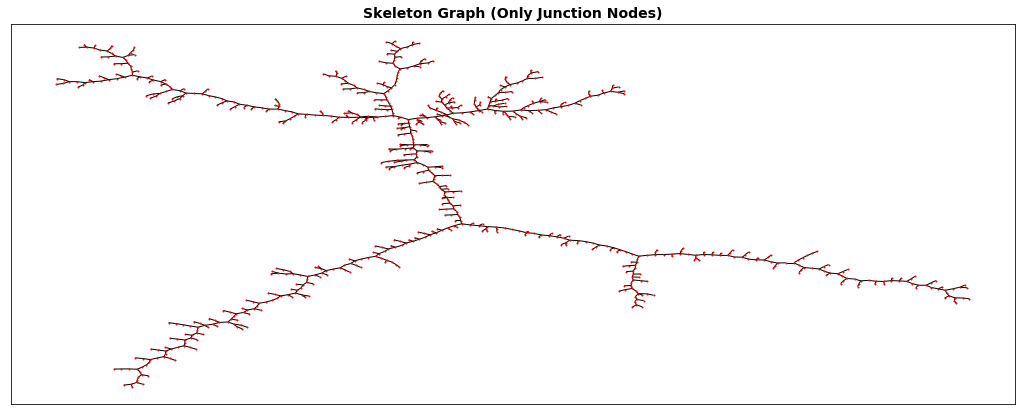

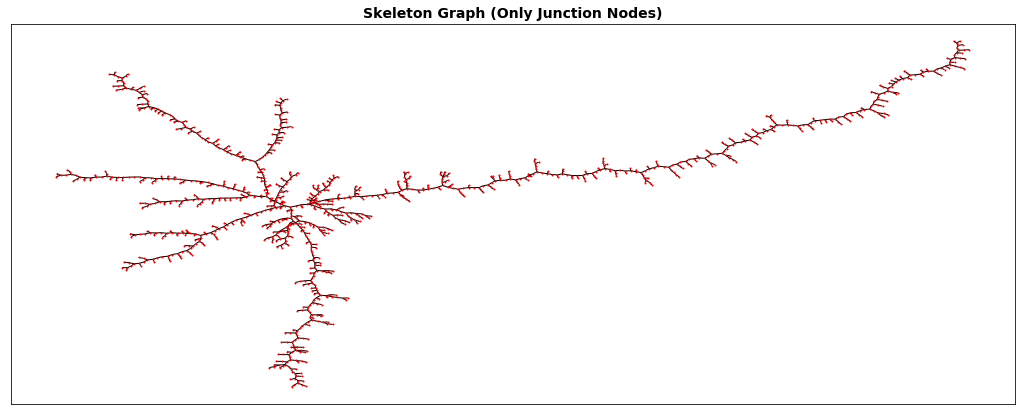

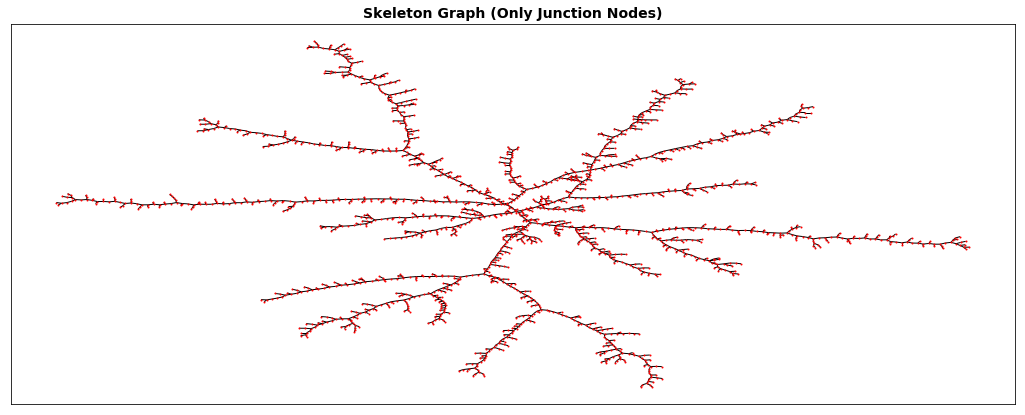

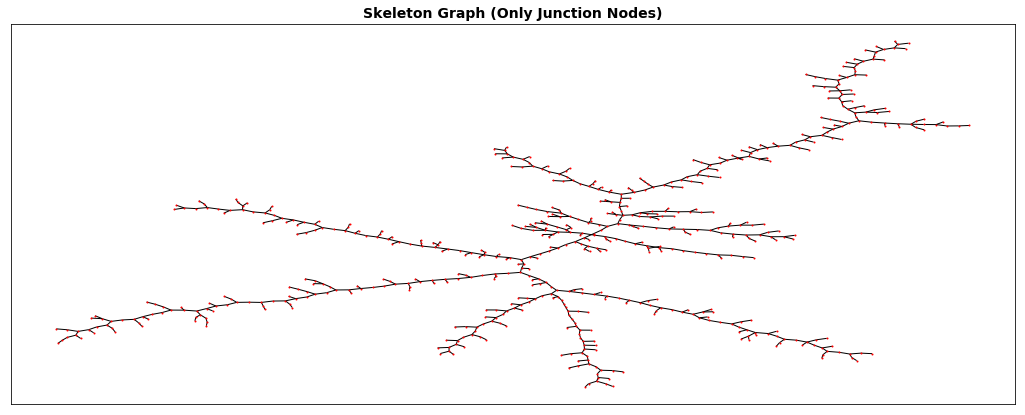

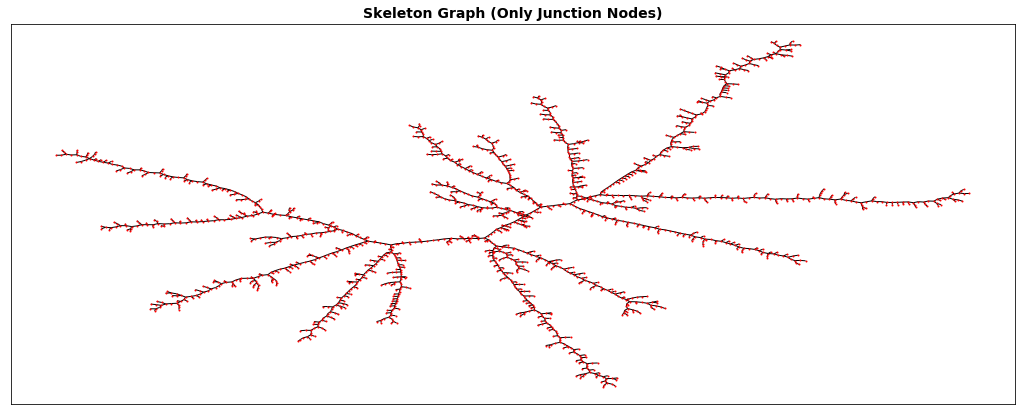

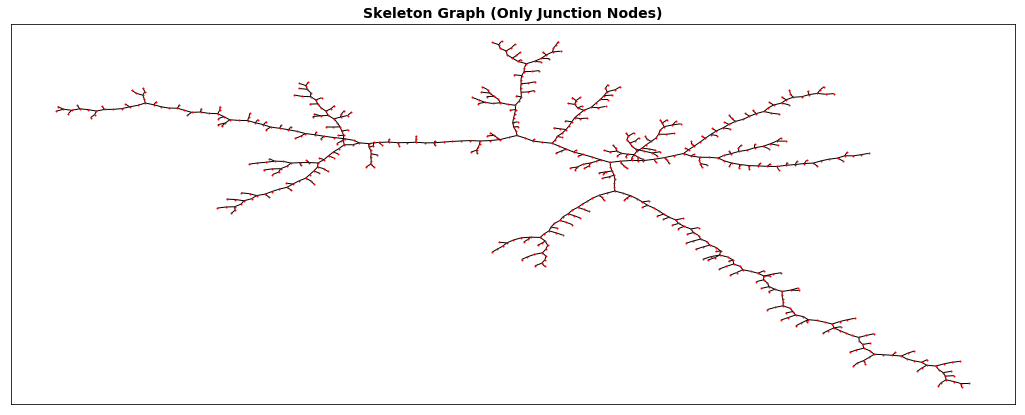

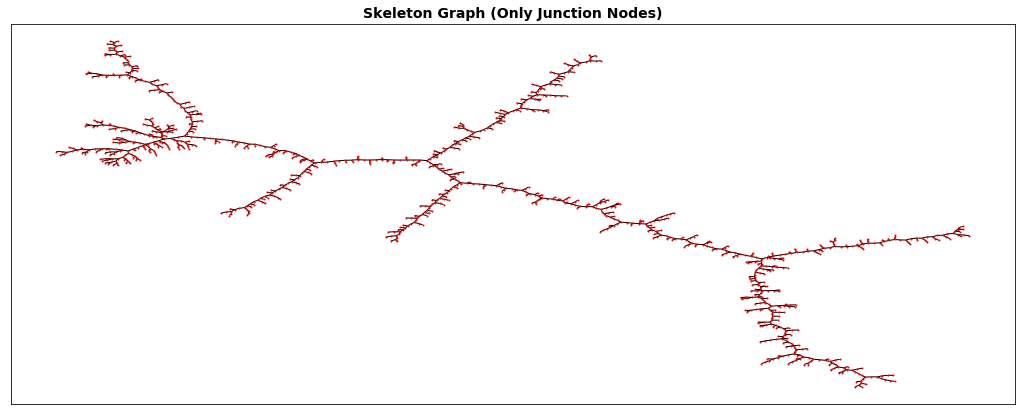

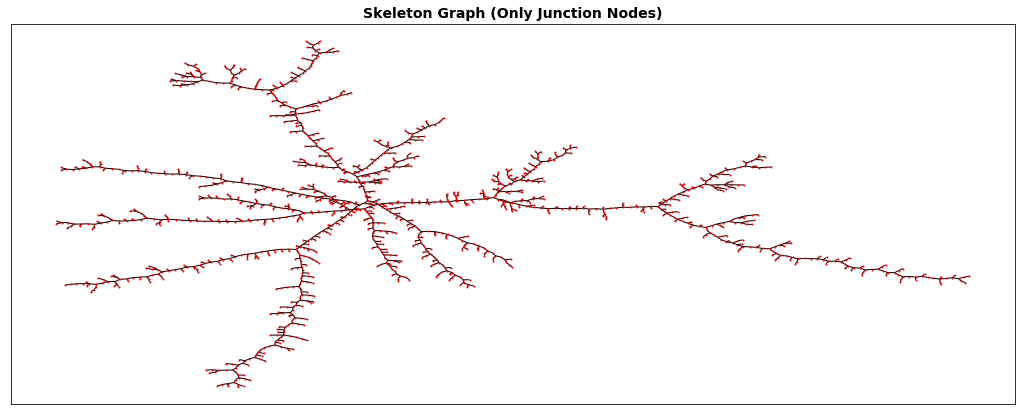

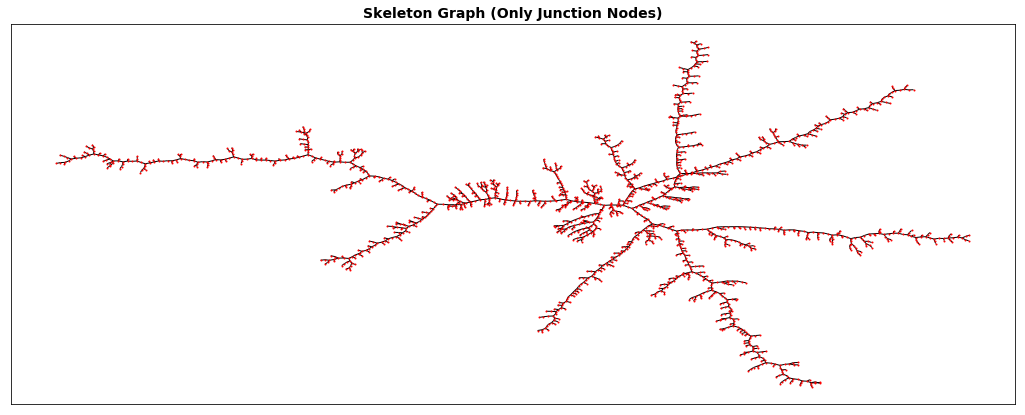

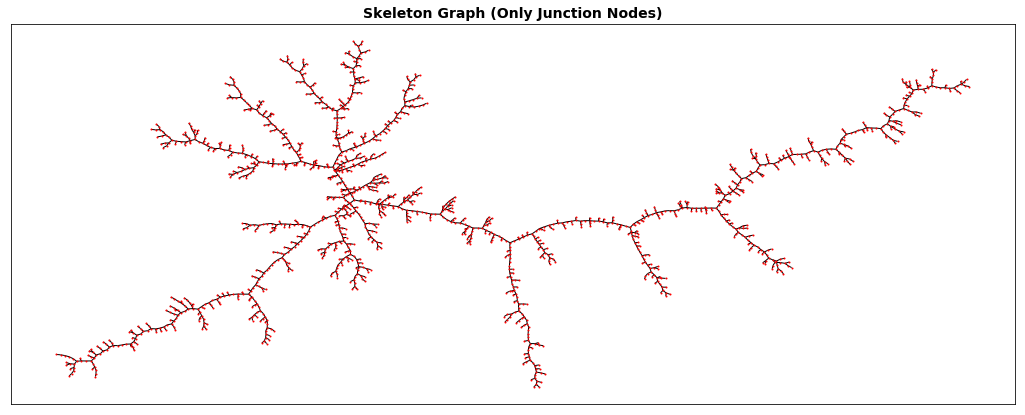

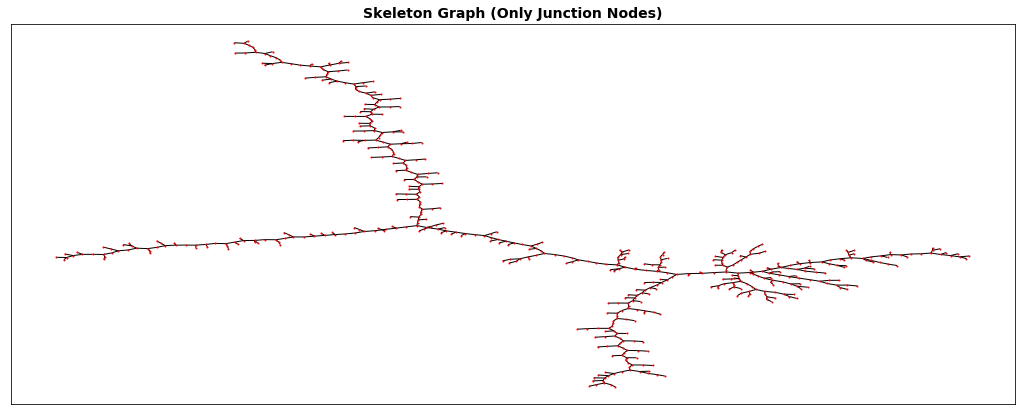

In [36]:
pyr_id = 25

in_dir = '/home/abhimanyu/final_data/pyramid{}_aligned/'.format(pyr_id)
voxel_dir = os.path.join(in_dir, 'voxel')
out_dir = '/var/www/html/abhi/final_data/pyramid{}'.format(pyr_id)
gx_dir = os.path.join(out_dir, 'networkx_no_processing')

seg_dict = {}
# pyr5
seg_dict[5] = [86,55,59,48,91]

# pyr25
seg_dict[25] = [67,69,70,75,83,26,27,29,30,34,35,43,53,54,56,63,90,114,32,41,92,97,99,100,104]

segs = seg_dict[pyr_id]
# segs = [26]

for seg_id in segs:
    skel=None
    try:
        1
#         skel = SaveSkelAndMesh(in_dir=in_dir, voxel_dir=voxel_dir, seg_id=seg_id, \
#                                    out_dir=out_dir, verbose=False, return_dt=False, plot_type='nodes')
    except:
        print('Error savings skel and mesh for ID {}'.format(seg_id))
        continue

    threshold = 0.0
    percentile = None
    MakeAndPlotGraph(voxel_dir=voxel_dir, seg_id=seg_id, graph_dir=out_dir, \
                        skel=skel, threshold=threshold, gx_dir=gx_dir, show_orig=False, \
                    percentile=percentile, save_graphx=True, save_graph=False, \
                    prune_jns=True, show_wts=False, modified_bfs=False)
    print('Done segment {:.0f}'.format(seg_id))

# All code below is for testing and experimenting with toy examples

In [ ]:
# ============================================== #
# Toy example for checking graph generation code #
# ============================================== #

# orig_graph = {0 : [1],
#                 1: [0,2,3, 4],
#                 2: [1,3, 5],
#                 3: [1,2,4, 5],
#                 4: [3, 1],
#                 5: [2,3]}

# # orig_graph = {0: [1],
# #               1: [0, 2, 4],
# #               2: [1, 3],
# #               3: [2, 4],
# #               4: [3, 1]
# #               }

# new_graph = {}
# visited = [False]*len(orig_graph)
# src = 0
# visited[src] = True
# trg = orig_graph[src][0]
# ModifiedBFS([src], orig_graph, new_graph, visited, [], use_euclid=False, debug=False)
# edgelist_new_ = GetEdgeList(new_graph)
# edgelist_orig_ = GetEdgeList(orig_graph)

# fig, ax = plt.subplots(2,1)
# DrawGraph(ax[0], edgelist_orig_, labels=True)
# ax[0].set_title('Original');
# DrawGraph(ax[1], edgelist_new_, labels=True)
# ax[1].set_title('New');
# fig.set_size_inches(8, 10)

In [ ]:
def PrintSummary(G):
    print('Summary')
    for e in zip(G.edges, G.edges.values()):
        edge_ = 'Edge({}, {})'.format(e[0][0], e[0][1])
        wt_ = 'Weight: {:.2f}'.format(e[1]['weight'])
        print(edge_ + ' '*(20 - len(edge_)) + wt_)
def TestShrink1(G, threshold, debug=False):
    """ 
        Do not contract an edge if contraction will 
        lead to multiple edges between two nodes.
    """
    if debug: PrintSummary(G)
    while True:
        wts = np.array([d['weight'] for d in G.edges.values()])
        idx = np.asarray(wts < threshold).nonzero()[0]
        if len(idx) == 0:
            break
        u,v = None, None
        for i in idx:
            a1, a2 = G.edges.items()[i][0] 
            s1, s2 = set(G[a1].keys()), set(G[a2].keys())
            if len(s1.difference({a2}) & s2.difference({a1})) == 0:
                u, v = a1, a2
                break
        if u is None:
            break
        G = nx.contracted_nodes(G, u, v, self_loops=False)
        if debug: 
            print('Deleted edge {}-{}'.format(u, v))
            PrintSummary(G)
    return G

def TestShrink2(G, threshold, debug=False, prune_jns=True):
    """ 
        Do not contract an edge if edge part of a triangle loop 
        with length shorter than the threshold.
    """
    def GetOrphan(a1, a2, s1, s2, G):
        orphan_, other_, orph_node_ = None, None, None
        if len(s1) == 0 and len(s2) == 2: orphan_ = a2; other_ = a1;
        if len(s2) == 0 and len(s1) == 2: orphan_ = a1; other_ = a2;
        # if no edge exists between two adjacent nodes 
        # of orphan, then orphan can be deleted.
        if orphan_ is not None:
            orph_node_ = a1
            m, n = set(G[orphan_].keys()).difference({other_})
            if n not in G[m].keys():
                return orph_node_
        return None
            
    if debug: PrintSummary(G)
    while True:
        wts = np.array([d['weight'] for d in G.edges.values()])
        if prune_jns:
            idx = np.asarray(wts < threshold).nonzero()[0]
        else:
            mask = [(len(G[e[0][0]].keys()) == 1) or (len(G[e[0][1]].keys()) == 1) \
                    for e in G.edges.items()]
            idx = np.asarray((wts < threshold) & mask).nonzero()[0]
        
        if len(idx) == 0:
            break
        u,v = None, None
        orphan_node = None
        for i in idx:
            a1, a2 = G.edges.items()[i][0] 
            s1, s2 = set(G[a1].keys()).difference({a2}), \
                        set(G[a2].keys()).difference({a1})
            intersect_ = s1 & s2
            # If no common node in adjacency list then break
            if len(intersect_) == 0:
                u, v = a1, a2
                orphan_node = GetOrphan(a1, a2, s1, s2, G)
                break
            # Else, make sure no triangular loop of decent size breaks
            else:
                crucial_edge = False
                for n in intersect_:
                    w1 = G.get_edge_data(n, a1)['weight']
                    w2 = G.get_edge_data(n, a2)['weight']
                    # if a loop (containing this edge) with 
                    # len > 3*thresh exists, don't delete this edge
                    if w1 + w2 > 3*threshold - wts[i]:
                        crucial_edge = True
                        break
                if not crucial_edge:
                    u, v = a1, a2
                    orphan_node = GetOrphan(a1, a2, s1, s2, G)
                    break
        if u is None:
            break
        G = nx.contracted_nodes(G, u, v, self_loops=False)
        if orphan_node is not None:
            m, n = G[orphan_node].keys()
            wm, wn = G[orphan_node][m]['weight'], G[orphan_node][n]['weight']
            # add edge between m and n
            G.add_edge(m, n, weight=(wm+wn))
            # delete orphan node
            G.remove_node(orphan_node)
        if debug: 
            print('Deleted edge {}-{}'.format(u, v))
            PrintSummary(G)
    return G

In [ ]:
# G_shrink = TestShrink2(G, threshold=4.0, debug=True)

In [ ]:
# nx.draw_networkx(G_shrink)

In [ ]:
# nx.draw_networkx(G)

In [ ]:
# # ============================================== #
# # Toy example for checking graph contraction     #
# # ============================================== #

# G1 = nx.Graph()
# edgelist1 = [[1, 2, {'weight' : 1.0}], \
#            [2, 3, {'weight' : 1.0}], \
#            [3, 1, {'weight' : 1.0}], \
#             [2, 4, {'weight' : 1.0}], \
#             [3, 4, {'weight' : 1.0}] \
#            ]
# G1.add_edges_from(edgelist1)

# G2 = nx.Graph()
# edgelist2 = [[1, 2, {'weight' : 5.0}], \
#            [2, 3, {'weight' : 5.0}], \
#            [3, 4, {'weight' : 5.0}], \
#             [2, 5, {'weight' : 2.0}], \
#             [3, 5, {'weight' : 5.0}], \
#              [2, 6, {'weight' : 5.0}], \
#             [3, 6, {'weight' : 5.0}]
#            ]
# G2.add_edges_from(edgelist2)

# G3 = nx.Graph()
# edgelist3 = [[1,8, {'weight': 1.0}], \
#              [8,9, {'weight': 1.0}], \
#              [9,2, {'weight': 1.0}], \
#             [1,4, {'weight': 1.0}], \
#             [4,5, {'weight': 1.0}], \
#             [5,2, {'weight': 1.0}], \
#             [1,6, {'weight': 1.0}], \
#             [6,7, {'weight': 1.0}], \
#             [7,2, {'weight': 1.0}], \
#             ]
# G3.add_edges_from(edgelist3)

# G4 = nx.Graph()
# edgelist4 = [[1,2, {'weight': 5.0}], \
#             [2,3, {'weight': 1.0}], \
#              [2,4, {'weight': 1.0}], \
#              [4,5, {'weight': 1.0}], \
#              [4,6, {'weight': 5.0}], \
#              [4,7, {'weight': 5.0}], \
#              [2,8, {'weight': 1.0}], \
#             ]
# G4.add_edges_from(edgelist4)

G5 = nx.Graph()
edgelist5 = [[1,2, {'weight' : 1.0}], \
             [1,3, {'weight' : 1.0}], \
             [1,4, {'weight' : 1.0}], \
             [4,5, {'weight' : 1.0}], \
             [4,6, {'weight' : 1.0}], \
             [4,7, {'weight' : 1.0}], \
             [7,8, {'weight' : 1.0}], \
             [7,9, {'weight' : 1.0}], \
             [7,10, {'weight' : 1.0}], \
            ]
G5.add_edges_from(edgelist5)

In [ ]:
G5.edges.values()

In [ ]:
nx.draw_networkx(G5)

In [ ]:
try:
    cycle_ = nx.find_cycle(G5, orientation='ignore')
except nx.NetworkXNoCycle:
    print('No cycles.')

In [ ]:
G_r = TestShrink2(G5, threshold=2.0, prune_jns=True)
nx.draw_networkx(G_r)

In [ ]:
G_r.edges.items()

In [ ]:
# read and write Graphs
# nx.write_gpickle(G, './G.obj')
# g_path = '/var/www/html/abhi/final_data/cell47/networkx_v1/1025_networkx.obj'
# G1 = nx.read_gpickle(g_path)

In [3]:
a = np.zeros(3+5)

In [4]:
for i in range(3):
    a[i] = 10
for i in range(5):
    a[-1-i] = 20
a

array([10., 10., 10., 20., 20., 20., 20., 20.])